In [39]:
import sys
import importlib
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,"../")
import mplhep as hep
import pickle
import glob
import ROOT
import coffea
import awkward as ak
from coffea import processor
from coffea.nanoevents.methods import vector
import dask_awkward as dak
import hist

In [40]:
sys.path.insert(0,"../python/HNL_Plotting_HelperFunctions")
import MuonSystemReader
import Produce_Cutflow
import Processing_Helpers


In [41]:
### NOTE: for this sample in data, the tau energy branch is messed up ###




data_path_base = "root://cmseos.fnal.gov//store/group/lpclonglived/amalbert/HNL_Tau_Search/2024_Data_noEtaCut/"

data_samples = ["Muon0-Run2024B-PromptReco-v1",
    "Muon0-Run2024C-PromptReco-v1",
    "Muon0-Run2024D-PromptReco-v1",
    "Muon0-Run2024E-PromptReco-v1",
    "Muon0-Run2024E-PromptReco-v2",
    "Muon0-Run2024F-PromptReco-v1",
    "Muon0-Run2024G-PromptReco-v1",
    "Muon0-Run2024H-PromptReco-v1",
    "Muon0-Run2024I-PromptReco-v1",
    "Muon0-Run2024I-PromptReco-v2",
    "Muon1-Run2024B-PromptReco-v1",
    "Muon1-Run2024C-PromptReco-v1",
    "Muon1-Run2024D-PromptReco-v1",
    "Muon1-Run2024E-PromptReco-v1",
    "Muon1-Run2024E-PromptReco-v2",
    "Muon1-Run2024F-PromptReco-v1",
    "Muon1-Run2024G-PromptReco-v1",
    "Muon1-Run2024H-PromptReco-v1",
    "Muon1-Run2024I-PromptReco-v1",
    "Muon1-Run2024I-PromptReco-v2"
    ]

data_events_list = [data_path_base+sample+"/normalized/"+sample+"_goodLumi.root" for sample in data_samples]
data_events_original  = MuonSystemReader.loadTree_nanoFactory(data_events_list)


In [42]:
data_events.fields

['runNum',
 'MC_condition',
 'lumiSec',
 'evtNum',
 'mH',
 'mX',
 'ctau',
 'HLT_CSCCSC',
 'HLT_CSCDT',
 'HLT_CscCluster100_PNetTauhPFJet10_Loose',
 'HLT_CscCluster100_Ele5',
 'HLT_CscCluster100_Mu5',
 'HLT_CscCluster50_Photon30Unseeded',
 'HLT_CscCluster50_Photon20Unseeded',
 'HLT_PFMET120_PFMHT120_IDTight',
 'jetVeto',
 'npv',
 'npu',
 'weight',
 'pileupWeight',
 'pileupWeightUp',
 'pileupWeightDown',
 'Flag_eeBadScFilter',
 'Flag_BadPFMuonFilter',
 'Flag_hfNoisyHitsFilter',
 'Flag_BadPFMuonDzFilter',
 'Flag_globalSuperTightHalo2016Filter',
 'Flag_EcalDeadCellTriggerPrimitiveFilter',
 'Flag_goodVertices',
 'Flag_all',
 'Flag_ecalBadCalibFilter',
 'LHEScaleWeight',
 'MetTriggerEffDown',
 'MetTriggerEffUp',
 'MetTriggerEff',
 'rho',
 'met',
 'metPhi',
 'Puppimet',
 'PuppimetPhi',
 'PuppimetJESUp',
 'PuppimetPhiJESUp',
 'PuppimetJESDown',
 'PuppimetPhiJESDown',
 'metJESUp',
 'metJESDown',
 'metPhiJESUp',
 'metPhiJESDown',
 'gHiggsPt',
 'gHiggsE',
 'gHiggsEta',
 'gHiggsPhi',
 'nCscRings',

In [57]:
HNL_2GeV_10ctau_path = "root://cmseos.fnal.gov//store/group/lpclonglived/amalbert/HNL_Tau_Search/signal_displacedHNL/HNL_tau_mN_2_ctau_1000/normalized/HNL_tau_mN_2_ctau_1000.root"
signal_events_original  = MuonSystemReader.loadTree_nanoFactory(HNL_2GeV_10ctau_path)


In [68]:
(1 - signal_events_original.cscRechitClusterHMTEfficiency).compute()

<Array [[], [], [], [], ..., [], [], [1], []] type='496100 * [var * float32...'>

In [66]:
signal_events_cluster = signal_events_original[signal_events_original.nCscRechitClusters>1]
(signal_events_cluster.cscRechitClusterHMTEfficiency).compute()

<Array [[0, 0], [0, 0], ..., [0, ...], [0, 0]] type='864 * [var * float32[p...'>

In [52]:
ak.count_nonzero(signal_events_original.nCscRechitClusters>0).compute()

27859

In [18]:
signal_events = signal_events_original[signal_events_original.HLT_CscCluster100_PNetTauhPFJet10_Loose]
signal_events = signal_events[signal_events.nCscRechitClusters==1]
#signal_events = signal_events[ak.all((signal_events.cscRechitClusterSize>160) & ((signal_events.cscRechitClusterNRechitChamberPlus13 + signal_events.cscRechitClusterNRechitChamberPlus21 + signal_events.cscRechitClusterNRechitChamberMinus13 + signal_events.cscRechitClusterNRechitChamberMinus21)==0), axis=1)]
#signal_events = signal_events[ak.flatten((signal_events.cscRechitClusterSize>160) & (signal_events.cscRechitClusterNStation10>1))]
signal_events = signal_events[ak.flatten((signal_events.cscRechitClusterSize>160))]

In [19]:
data_events = data_events_original[data_events_original.nCscRechitClusters==1]
#data_events = data_events[ak.all((data_events.cscRechitClusterSize>160) & ((data_events.cscRechitClusterNRechitChamberPlus13 + data_events.cscRechitClusterNRechitChamberPlus21 + data_events.cscRechitClusterNRechitChamberMinus13 + data_events.cscRechitClusterNRechitChamberMinus21)==0), axis=1)]
#data_events = data_events[ak.flatten((data_events.cscRechitClusterSize>160) & (data_events.cscRechitClusterNStation10>1))]
data_events = data_events[ak.flatten((data_events.cscRechitClusterSize>160))]

Text(0, 0.5, 'Density')

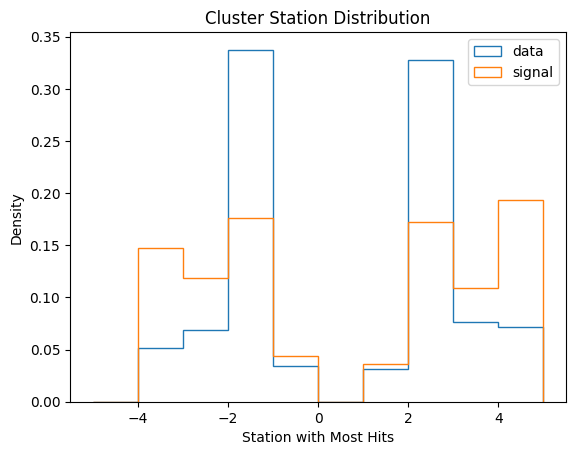

In [ ]:
bins = np.arange(-5, 6)
data_stations = ak.flatten(data_events.cscRechitClusterMaxStation).compute()
signal_stations = ak.flatten(signal_events.cscRechitClusterMaxStation).compute()
plt.hist(data_stations, density=True, label="data", histtype="step", bins=bins)
plt.hist(signal_stations, density=True, label="signal", histtype="step", bins=bins)
plt.legend()
plt.title("Cluster Station Distribution")
plt.xlabel("Station with Most Hits")
plt.ylabel("Density")

Text(0, 0.5, 'Density')

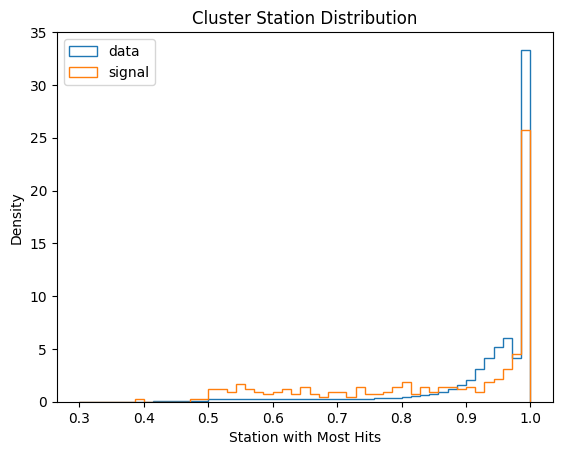

In [ ]:
data_events_fraction = data_events[ak.flatten(abs(data_events.cscRechitClusterMaxStation)>2)]
signal_events_fraction = signal_events[ak.flatten(abs(signal_events.cscRechitClusterMaxStation)>2)]
data_fraction = data_events_fraction.cscRechitClusterMaxStationRatio.compute()
signal_fraction = signal_events_fraction.cscRechitClusterMaxStationRatio.compute()
plt.hist(data_fraction, density=True, label="data", histtype="step", bins=np.linspace(0.3,1, 50))
plt.hist(signal_fraction, density=True, label="signal", histtype="step", bins=np.linspace(0.3,1, 50))
plt.legend()
plt.title("Cluster Station Distribution")
plt.xlabel("Station with Most Hits")
plt.ylabel("Density")

Text(0, 0.5, 'Density')

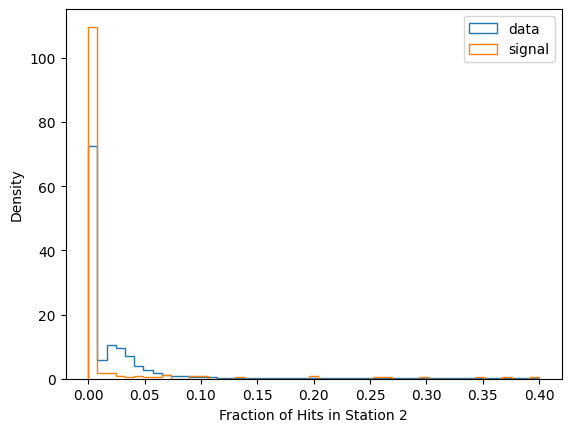

In [ ]:
data_events = data_events[ak.flatten(abs(data_events.cscRechitClusterMaxStation)>2)]
signal_events = signal_events[ak.flatten(abs(signal_events.cscRechitClusterMaxStation)>2)]
data_numerator = data_events.cscRechitClusterNRechitChamberMinus21 + data_events.cscRechitClusterNRechitChamberMinus22 + data_events.cscRechitClusterNRechitChamberPlus21 + data_events.cscRechitClusterNRechitChamberPlus22
data_fraction2 = (data_numerator/data_events.cscRechitClusterSize).compute()
signal_numerator = signal_events.cscRechitClusterNRechitChamberMinus21 + signal_events.cscRechitClusterNRechitChamberMinus22 + signal_events.cscRechitClusterNRechitChamberPlus21 + signal_events.cscRechitClusterNRechitChamberPlus22
signal_fraction2 = (signal_numerator/signal_events.cscRechitClusterSize).compute()
plt.hist(data_fraction2, density=True, label="data", histtype="step", bins=np.linspace(0,0.4, 50))
plt.hist(signal_fraction2, density=True, label="signal", histtype="step", bins=np.linspace(0,0.4, 50))
plt.legend()
plt.title("")
plt.xlabel("Fraction of Hits in Station 2")
plt.ylabel("Density")

Text(0, 0.5, 'Density')

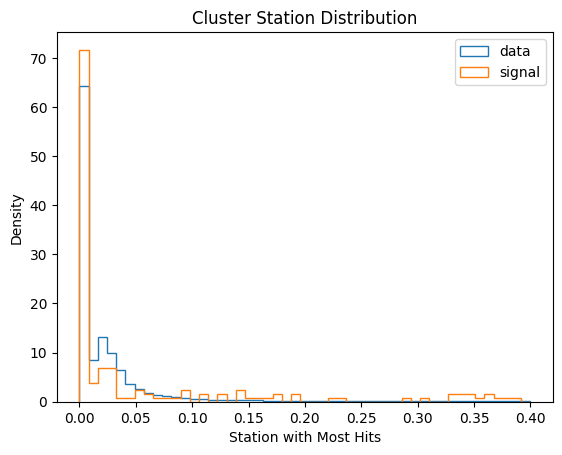

In [ ]:
data_events = data_events[ak.flatten(abs(data_events.cscRechitClusterMaxStation)>2)]
signal_events = signal_events[ak.flatten(abs(signal_events.cscRechitClusterMaxStation)>2)]
data_numerator = data_events.cscRechitClusterNRechitChamberMinus31 + data_events.cscRechitClusterNRechitChamberMinus32 + data_events.cscRechitClusterNRechitChamberPlus31 + data_events.cscRechitClusterNRechitChamberPlus32
data_fraction2 = (data_numerator/data_events.cscRechitClusterSize).compute()
signal_numerator = signal_events.cscRechitClusterNRechitChamberMinus31 + signal_events.cscRechitClusterNRechitChamberMinus32 + signal_events.cscRechitClusterNRechitChamberPlus31 + signal_events.cscRechitClusterNRechitChamberPlus32
signal_fraction2 = (signal_numerator/signal_events.cscRechitClusterSize).compute()
plt.hist(data_fraction2, density=True, label="data", histtype="step", bins=np.linspace(0,0.4, 50))
plt.hist(signal_fraction2, density=True, label="signal", histtype="step", bins=np.linspace(0,0.4, 50))
plt.legend()
plt.title("Cluster Station Distribution")
plt.xlabel("Station with Most Hits")
plt.ylabel("Density")

Text(0, 0.5, 'Density')

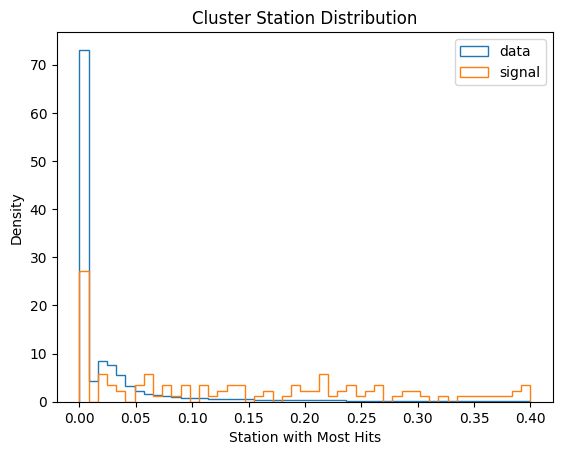

In [ ]:
data_events = data_events[ak.flatten(abs(data_events.cscRechitClusterMaxStation)>2)]
signal_events = signal_events[ak.flatten(abs(signal_events.cscRechitClusterMaxStation)>2)]
data_numerator = data_events.cscRechitClusterNRechitChamberMinus41 + data_events.cscRechitClusterNRechitChamberMinus42 + data_events.cscRechitClusterNRechitChamberPlus41 + data_events.cscRechitClusterNRechitChamberPlus42
data_fraction2 = (data_numerator/data_events.cscRechitClusterSize).compute()
signal_numerator = signal_events.cscRechitClusterNRechitChamberMinus41 + signal_events.cscRechitClusterNRechitChamberMinus42 + signal_events.cscRechitClusterNRechitChamberPlus41 + signal_events.cscRechitClusterNRechitChamberPlus42
signal_fraction2 = (signal_numerator/signal_events.cscRechitClusterSize).compute()
plt.hist(data_fraction2, density=True, label="data", histtype="step", bins=np.linspace(0,0.4, 50))
plt.hist(signal_fraction2, density=True, label="signal", histtype="step", bins=np.linspace(0,0.4, 50))
plt.legend()
plt.title("Cluster Station Distribution")
plt.xlabel("Station with Most Hits")
plt.ylabel("Density")

In [21]:
signal_events_noStation2 = signal_events[ak.flatten((signal_events.cscRechitClusterNRechitChamberMinus13+signal_events.cscRechitClusterNRechitChamberMinus21+signal_events.cscRechitClusterNRechitChamberMinus22+signal_events.cscRechitClusterNRechitChamberPlus13+signal_events.cscRechitClusterNRechitChamberPlus21+signal_events.cscRechitClusterNRechitChamberPlus22)==0)]


In [23]:
data_events_noStation2 = data_events[ak.flatten((data_events.cscRechitClusterNRechitChamberMinus13+data_events.cscRechitClusterNRechitChamberMinus21+data_events.cscRechitClusterNRechitChamberMinus22+data_events.cscRechitClusterNRechitChamberPlus13+data_events.cscRechitClusterNRechitChamberPlus21+data_events.cscRechitClusterNRechitChamberPlus22)==0)]

In [26]:
signal_events_noStation2.cscRechitClusterNStation10

dask.awkward<cscRechitClusterNStation10, npartitions=1>

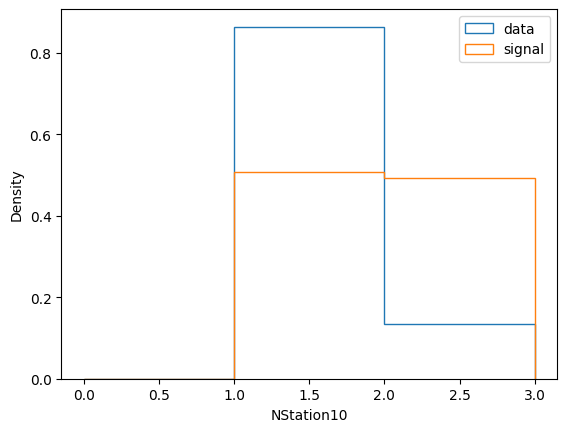

In [33]:
plt.hist(data_events_noStation2.cscRechitClusterNStation10.compute(), histtype='step', density=True, label="data", bins=np.linspace(0,3,4))
plt.hist(signal_events_noStation2.cscRechitClusterNStation10.compute(), histtype='step', density=True, label="signal", bins=np.linspace(0,3,4))
plt.ylabel("Density")
plt.xlabel("NStation10")
plt.legend()

In [38]:
signal_events.cscRechitClusterHMTEfficiency.compute()

<Array [[1], [0.989], ..., [0.991], [0.984]] type='521 * [var * float32[par...'>

In [37]:
data_events.runNum.compute()

<Array [379154, 379154, ..., 386694, 386694] type='2664373 * uint32[paramet...'>